# Body Pose Estimation 

In [1]:
import cv2 as cv 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [5]:
net = cv.dnn.readNetFromTensorflow("../trained_model/human-pose-estimation-opencv-master/graph_opt.pb") 

In [2]:
inWidth = 368 
inHeight = 368 
thr = 0.2 

In [8]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

# GrabCut Algorithm 
-  An algorithm was needed for foreground extraction with minimal user interaction, and the result was GrabCut.
-  Initially user draws a rectangle around the foreground region  (foreground region should be completely inside the rectangle).  Then algorithm segments it iteratively to get the best result.  

In [157]:
label_map = {
    1: "top", 
    2: "bottom", 
    3: "dress"
}

from detector import DetectorTF2 

detector = DetectorTF2(
    "../trained_model/frozen_model_1/saved_model/", 
    labelmap= label_map,
    threshold=0.50) 

In [160]:
img = cv.imread("../data/IMG_all/demo/v.png")

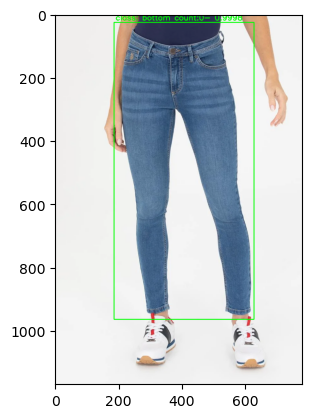

In [161]:
det_boxes = detector.DetectFromImage(img)
detected_img = detector.DisplayDetections(img, det_boxes) 

plt.imshow(cv.cvtColor(detected_img, cv.COLOR_BGR2RGBA))
plt.show() 

In [162]:
rect = tuple(det_boxes[0][:4])
rect

(186, 26, 628, 965)

In [163]:
rect = (rect[0], rect[1], rect[2] - rect[0], rect[3] - rect[1])
rect 

(186, 26, 442, 939)

In [164]:
mask = np.zeros(img.shape[:2], np.uint8) 
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

In [165]:
cv.grabCut(img,mask,rect,bgdModel,fgdModel,15,cv.GC_INIT_WITH_RECT)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[8.05667316e-01, 4.51337091e-02, 3.02245386e-02, 8.20733816e-02,
         3.69010551e-02, 2.41701642e+02, 2.42322307e+02, 2.42441406e+02,
         1.32761915e+02, 1.67857048e+02, 2.16691247e+02, 7.78456843e+01,
         4.77711528e+01, 4.37727617e+01, 2.39887179e+02, 2.39535925e+02,
         2.39176899e+02, 1.50973488e+02, 1.54082519e+02, 1.73235194e+02,
         7.21073596e+00, 5.63096512e+00, 4.84507859e+00, 5.63096512e+00,
         5.11537088e+00, 4.17293581e+00, 4.84507859e+00, 4.17293581e+00,
         3.75614603e+00, 3.17035881e+02, 2.41138547e+02, 1.65807306e+02,
         2.41138547e+02, 2.17469646e+02, 1.74726303e+02, 1.65807306e+02,
         1.74726303e+02, 1.77435886e+02, 9.99185010e+00, 8.65576988e+00,
         1.01908469e+01, 8.65576988e+00, 8.2

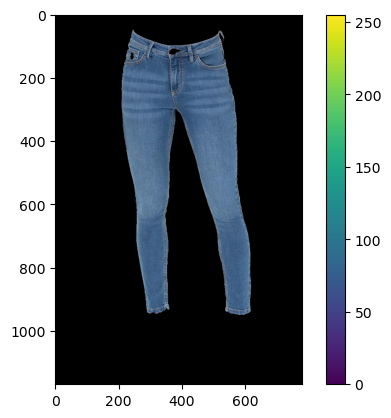

In [166]:
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img * mask2[:,:,np.newaxis]
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) 
plt.colorbar() 
plt.show()

# Body Pix 

In [ ]:
# !pip install tf_bodypix 
# !pip install tfjs_graph_converter 
# !pip show tfjs_graph_converter
# !pip install -U jax jaxlib

In [2]:
import tensorflow as tf 
from tf_bodypix.api import download_model, load_model, BodyPixModelPaths
import cv2 as cv 
import matplotlib.pyplot as plt 
import numpy as np 

In [3]:
# get the model 
bodypix_model = load_model(download_model(BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16))
bodypix_model

In [144]:
img = cv.imread("../data/IMG_all/demo/684.png")

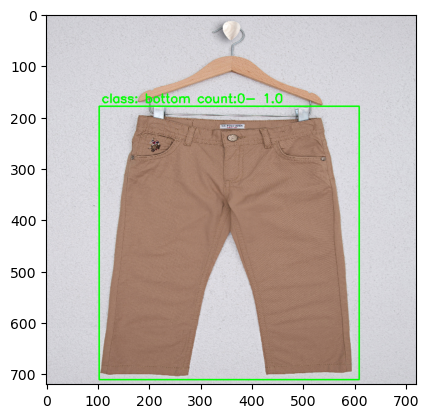

In [145]:
det_boxes = detector.DetectFromImage(img)
detected_img = detector.DisplayDetections(img, det_boxes) 

plt.imshow(cv.cvtColor(detected_img, cv.COLOR_BGR2RGBA))
plt.show() 

In [146]:
# crop the image 
img = img[det_boxes[0][1]:det_boxes[0][3] + 1, det_boxes[0][0]:det_boxes[0][2] + 1, :]

In [147]:
result = bodypix_model.predict_single(img) 
mask = result.get_mask(threshold=0.9).numpy().astype(np.uint8) 
masked_image = cv.bitwise_and(img, img, mask=mask) 

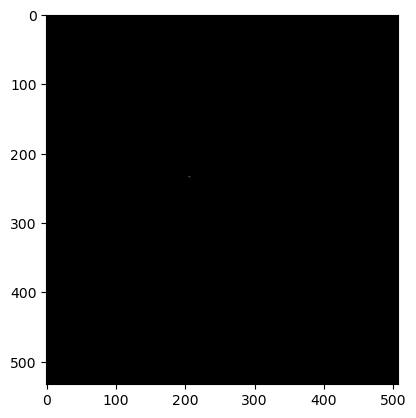

In [148]:
plt.imshow(cv.cvtColor(masked_image, cv.COLOR_BGR2RGB))
plt.show() 

In [130]:
[v.part for v in result.get_poses()[0].keypoints.values()]

['rightEye',
 'nose',
 'leftEye',
 'leftEar',
 'rightEar',
 'leftShoulder',
 'leftElbow',
 'leftWrist',
 'leftHip',
 'leftKnee',
 'leftAnkle',
 'rightShoulder',
 'rightElbow',
 'rightWrist',
 'rightHip',
 'rightKnee',
 'rightAnkle']

In [131]:
len(result.get_poses()[0].keypoints.keys() )

17

In [132]:
from tf_bodypix.bodypix_js_utils.keypoints import PART_NAMES, POSE_CHAIN, NUM_KEYPOINTS,PART_IDS

PART_IDS

{'nose': 0,
 'leftEye': 1,
 'rightEye': 2,
 'leftEar': 3,
 'rightEar': 4,
 'leftShoulder': 5,
 'rightShoulder': 6,
 'leftElbow': 7,
 'rightElbow': 8,
 'leftWrist': 9,
 'rightWrist': 10,
 'leftHip': 11,
 'rightHip': 12,
 'leftKnee': 13,
 'rightKnee': 14,
 'leftAnkle': 15,
 'rightAnkle': 16}

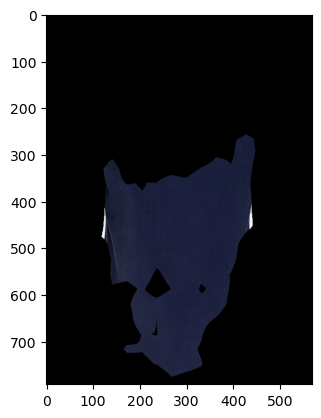

In [142]:
from numpy import unique, ravel 
s = result.get_scaled_part_segmentation(mask)
smask_13 = np.equal(s,12 ).astype(np.uint8) 
r = cv.bitwise_and(img, img, mask=smask_13) 
plt.imshow(cv.cvtColor(r, cv.COLOR_BGR2RGB))
plt.show()

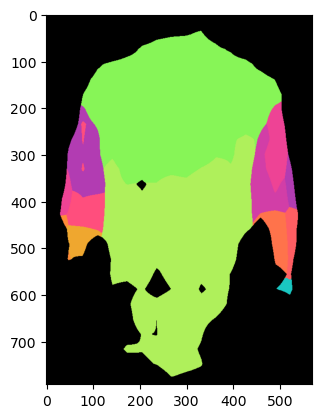

In [143]:
part_mask = result.get_colored_part_mask(mask)
plt.imshow(part_mask)
plt.show() 

In [119]:
np.unique(result.get_colored_part_mask(mask).reshape((img.shape[0] * img.shape[1],3)), axis=0) 

array([[  0,   0,   0],
       [ 47, 150, 224],
       [110,  64, 170],
       [135, 245,  87],
       [143,  61, 178],
       [175, 240,  91],
       [178,  60, 178],
       [210,  62, 167],
       [238,  67, 149],
       [239, 167,  47],
       [255,  78, 125],
       [255,  94,  99],
       [255, 140,  56]])

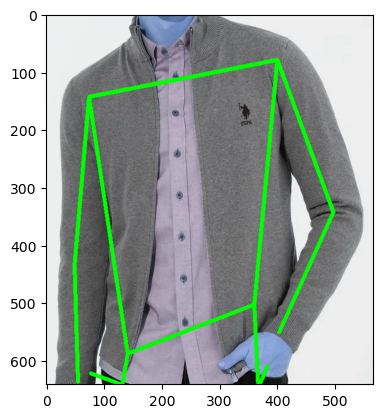

In [217]:
from tf_bodypix.draw import draw_poses, draw_keypoints, draw_skeleton, draw_pose
poses = result.get_poses()
image_with_poses = draw_skeleton(
    img.copy(),  # create a copy to ensure we are not modifing the source image
    [v for v in poses[0].keypoints.values()],
    color=(0, 255, 0),
    thickness=5
)

plt.imshow(image_with_poses) 
plt.show() 

In [220]:
poses[0].keypoints

{7: Keypoint(score=2.935504, position=Vector2D(y=342.5818167237849, x=497.1100897091431), part='leftElbow'),
 5: Keypoint(score=2.602035, position=Vector2D(y=78.54723626727998, x=399.7679997259008), part='leftShoulder'),
 0: Keypoint(score=-0.024449527, position=Vector2D(y=-20.809154055942997, x=225.51490727099747), part='nose'),
 1: Keypoint(score=0.77357423, position=Vector2D(y=-32.336749561107794, x=229.22062119983494), part='leftEye'),
 3: Keypoint(score=-0.30493858, position=Vector2D(y=-33.32197793027694, x=261.28733512420797), part='leftEar'),
 2: Keypoint(score=-0.69579935, position=Vector2D(y=-36.6190151767196, x=195.42734466454922), part='rightEye'),
 4: Keypoint(score=-1.34116, position=Vector2D(y=-36.056001571108624, x=152.8630282293746), part='rightEar'),
 9: Keypoint(score=2.6683176, position=Vector2D(y=551.4582010175848, x=402.95386431767395), part='leftWrist'),
 11: Keypoint(score=-2.079231, position=Vector2D(y=502.9074702396572, x=359.8357230734913), part='leftHip'),
 1

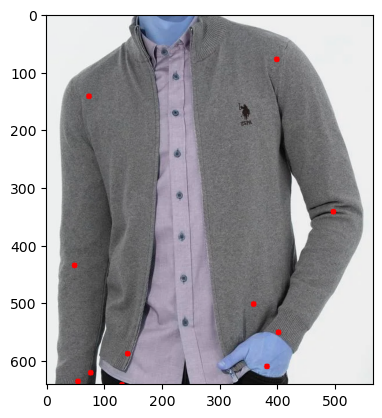

In [150]:
for k, v in result.get_poses()[0].keypoints.items(): 
    img = cv.circle(img, (int(v.position.x), int(v.position.y)), 5, (255,0, 0),-1)
    
plt.imshow(img)
plt.show() 